# Data Money Company 

The company Data Money provides Analysis and Data Science consulting services to large companies in Brazil and abroad.
Its main market differentiator in relation to competitors is the high financial return for client companies, thanks to the performance of its Machine Learning algorithms.
Data Money believes that the expertise in training and fine-tuning algorithms, carried out by the company's Data Scientists, is the main reason for the excellent results that the consultancies have been delivering to their clients.

To continue growing the team's expertise, Data Scientists believe that it is extremely important to carry out tests on Machine Learning algorithms to acquire more and more experience on how they work and in which scenarios the performances are maximum and minimum, so that the choice of algorithm for each situation is the most correct possible.

As a newly hired Data Scientist for the company, your main task will be to carry out 3 trials with Classification, Regression and Clustering algorithms, in order to extract insights into how they work in certain scenarios and be able to convey this knowledge to the rest of the team.

# 0 - Imports

In [1]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import plotly.express    as px
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from IPython.display                 import HTML, Markdown, display
from sklearn.cluster                 import KMeans, AffinityPropagation
from plotly.subplots                 import make_subplots
from sklearn.metrics                 import silhouette_score, adjusted_rand_score
from sklearn.metrics.cluster         import contingency_matrix
from yellowbrick.cluster             import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition           import PCA
from sklearn.model_selection         import ParameterGrid
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=UserWarning, module='numpy')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'Bitstream Vera Sans', 'DejaVu Sans']

/home/daniel/.pyenv/versions/3.12.4/envs/intro_ml/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


## 0.1 - Helper Functions

In [2]:
def perform_kmeans_visualization(data):
    """
    Perform KMeans clustering visualization to determine the optimal number of clusters
    and evaluate clustering quality using silhouette scores. The original dataset is not modified.

    Parameters:
    - data: The dataset to be clustered.

    Returns:
    - best_labels: The cluster labels assigned by the KMeans model with the optimal number of clusters.
    - silhouette_score: The silhouette score of the KMeans model with the optimal number of clusters.
    """
    # Create a copy of the dataset to ensure the original is not modified
    data_copy = data.copy()

    # Create KMeans model
    model = KMeans(random_state=0)

    # Elbow visualizer to find the optimal number of clusters based on Silhouette Score
    elbow_visualizer = KElbowVisualizer(model, metric='silhouette')
    elbow_visualizer.fit(data_copy)
    elbow_visualizer.show()

    # Get the recommended number of clusters
    best_n_clusters = elbow_visualizer.elbow_value_

    # Create KMeans model with the optimal number of clusters
    best_kmeans_model = KMeans(n_clusters=best_n_clusters, random_state=0)

    # Fit the best KMeans model to the data and get the cluster labels
    best_kmeans_model.fit(data_copy)
    best_labels = best_kmeans_model.labels_

    # Silhouette visualizer for the model with the best number of clusters
    silhouette_visualizer = SilhouetteVisualizer(best_kmeans_model, colors='yellowbrick')
    silhouette_visualizer.fit(data_copy)
    silhouette_visualizer.show()

    # Calculate silhouette score for the best KMeans model
    silhouette_score = silhouette_visualizer.silhouette_score_

    return best_labels, silhouette_score






def plot_cluster_profiles(data, cluster_labels, title='Cluster Profiles', figsize=(12, 6)):
    """
    This function generates a bar plot showing the mean values of features for each cluster.

    Parameters:
    - data: DataFrame containing the original data without the cluster labels.
    - cluster_labels: Array or Series containing the cluster labels assigned to each data point.
    - title: Title for the plot (default is 'Cluster Profiles').
    - figsize: Tuple specifying the figure size (default is (12, 6)).

    Returns:
    - A bar plot displaying the mean feature values for each cluster.
    """
    # Create a copy of the dataset to ensure the original is not modified
    data_copy = data.copy()
    
    # Copy the original data and add the cluster labels
    df_clusters = data_copy
    df_clusters['cluster'] = cluster_labels

    # Compute the mean profile of each cluster
    cluster_profiles = df_clusters.groupby('cluster').mean()

    # Create a color palette
    palette_set1 = sns.color_palette("Set1", 9) 
    palette_dark2 = sns.color_palette("Dark2", 4)  
    palette_custom = palette_set1 + palette_dark2  

    # Create the bar plot
    fig, ax = plt.subplots(figsize=figsize)
    cluster_profiles.plot(kind='bar', ax=ax, color=palette_custom)

    # Customize the plot
    plt.xlabel('Clusters')
    plt.ylabel('Mean Value')
    plt.title(title)
    plt.legend(title='Clusters', bbox_to_anchor=(1, 1.02))
    plt.xticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()




def perform_pca_kmeans(data, n_components):
    """
    Perform PCA followed by KMeans clustering and 3D visualization.

    Parameters:
    - X_data: The dataset to perform PCA on.
    - n_components: The number of PCA components to use.

    Returns:
    - best_results: A dictionary containing the silhouette score and cluster labels.
    """

    # Create a copy of the dataset to ensure the original is not modified
    data_copy = data.copy()
    
    best_results = {}

    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_copy)

    # Determine optimal number of clusters using visualization
    best_labels, best_silhouette_score = perform_kmeans_visualization(principal_components)

    # Create DataFrame with principal components and cluster labels
    columns = [f'PC{i+1}' for i in range(n_components)]
    principal_df = pd.DataFrame(data=principal_components, columns=columns)
    principal_df['Cluster'] = best_labels

    # Check if 3D plotting is feasible
    if n_components == 3:
        fig = px.scatter_3d(principal_df, x='PC1', y='PC2', z='PC3', color='Cluster',
                            title=f'PCA 3D Plot with {n_components} Components',
                            color_continuous_scale="Portland")
        fig.update_layout(
            scene=dict(
                xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)',
                yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)',
                zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2] * 100:.2f}%)'
            ),
            height=1000,
            width=1000,
            plot_bgcolor='#f6f6f6'
        )
        fig.show()
    elif n_components == 2:
        fig = px.scatter(principal_df, x='PC1', y='PC2', color='Cluster',
                         title=f'PCA 2D Plot with {n_components} Components',
                         color_continuous_scale="Portland")
        fig.update_layout(
            xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)',
            yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)',
            height=1000,
            width=1000,
            plot_bgcolor='#f6f6f6'
        )
        
        fig.show()
    else:
        print("PCA components must be 2 or 3 for visualization.")

    return best_labels, best_silhouette_score





def perform_affinity_propagation_grid_search(data, preferences):
    """
    Perform a grid search for Affinity Propagation clustering with different preferences and return the best parameters
    based on the highest silhouette score.

    Parameters:
    - X_data: The dataset to be clustered.
    - preferences: List of preferences to be tested.

    Returns:
    - best_preference: The best preference value.
    - best_ss: Best silhouette score.
    - best_labels: Labels from the best clustering result.
    """
    # Create a copy of the dataset to ensure the original is not modified
    data_copy = data.copy()
    
    results = []
    best_ss = -1
    best_labels = None
    best_preference = None

    for preference in preferences:
        affinity_propagation = AffinityPropagation(preference=preference, random_state=0)
        labels = affinity_propagation.fit_predict(data_copy)
        
        # Check if the number of clusters is more than 1
        if len(set(labels)) > 1:
            ss = silhouette_score(data_copy, labels)
            results.append({
                'preference': preference,
                'silhouette_score': ss
            })
            
            if ss > best_ss:
                best_ss = ss
                best_labels = labels
                best_preference = preference

        # print(f"Preference: {preference} - Silhouette Score: {ss:.4f}" if len(set(labels)) > 1 else f"Preference: {preference} - Skipped due to single cluster")

    # Print best parameters and silhouette score
    print(f"\nBest Preference: {best_preference}")
    print(f"Best Silhouette Score: {best_ss:.4f}")
    print(f'N Clusters: {len(np.unique(best_labels))}')

    # Plot silhouette scores
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=results_df, x='preference', y='silhouette_score', markers=True)
    plt.xlabel('Preference')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Score vs Preference')
    plt.grid(True)
    plt.show()

    return best_preference, best_ss, best_labels





def plot_comparison_3_methods(labels_1, labels_2, labels_3, method_1, method_2, method_3):
    methods = [(labels_1, method_1), (labels_2, method_2), (labels_3, method_3)]
    
    # Generate all combinations of pairs from the three methods
    for i in range(len(methods)):
        for j in range(i + 1, len(methods)):
            labels_a, method_a = methods[i]
            labels_b, method_b = methods[j]
            
            # Calculate the contingency matrix
            contingency = contingency_matrix(labels_a, labels_b)

            # Create a DataFrame from the contingency matrix
            df_contingency = pd.DataFrame(contingency, 
                                          columns=[f'Cluster {i} - {method_a}' for i in range(contingency.shape[1])],
                                          index=[f'Cluster {i} - {method_b}' for i in range(contingency.shape[0])])

            # Plot both the heatmap and the stacked bar chart side by side
            fig, axes = plt.subplots(1, 2, figsize=(20, 8))

            # Heatmap
            sns.heatmap(df_contingency, 
                        annot=True, 
                        cmap='viridis', 
                        fmt='d', linewidths=0.5, ax=axes[0])
            axes[0].set_title(f'Contingency Matrix Heatmap\n{method_a} vs {method_b}')
            axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

            # Stacked Bar Chart
            df_contingency.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
            axes[1].set_title(f'Distribution of {method_a} Clusters\nwithin {method_b} Clusters')
            axes[1].set_ylabel('Number of Samples')
            axes[1].legend(title=f'{method_b} Clusters')
            axes[1].set_xticklabels([f'Cluster {i} - {method_b}' for i in range(contingency.shape[1])], rotation=0)

            plt.tight_layout()
            plt.show()
            plt.close(fig)
            print('\n\n')




def color_clusters(row):
    color = ''
    if row['Cluster'] == 0:
        color = 'background-color: #add8e6'  # Azul pastel
    elif row['Cluster'] == 1:
        color = 'background-color: #fffacd'  # Amarelo pastel
    elif row['Cluster'] == 2:
        color = 'background-color: #ffb6c1'  # Coral pastel
    return [color] * len(row)

# 1 - Loading data

In [3]:
X_data = pd.read_csv('Data/Clustering/X_dataset.csv')
X_data.head()

alcohol  malic_acid       ash  ash_alcanity  magnesium  total_phenols  \
0  1.518613    0.191700  0.232053     -1.169593   1.913905       0.627586   
1  0.246290    0.205534 -0.827996     -2.490847   0.018145       0.575862   
2  0.196879    0.320158  1.109334     -0.268738   0.088358       0.627586   
3  1.691550    0.239130  0.487926     -0.809251   0.930918       0.989655   
4  0.295700    0.365613  1.840403      0.451946   1.281985       0.627586   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity  \
0    0.573840             -0.659563         1.224884         0.251717   
1    0.510549             -0.820719        -0.544721        -0.293321   
2    0.611814             -0.498407         2.135968         0.269020   
3    0.664557             -0.981875         1.032155         1.186068   
4    0.495781              0.226796         0.401404        -0.319276   

        hue     od280   proline  
0  0.455285  0.970696  0.561341  
1  0.463415  0.780220  0.550642  
2  0.447154  0.695971  0.646933  
3  0.308943  0.798535  0.857347  
4  0.455285  0.608059  0.325963

# 2 - EDA

In [4]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alcohol               178 non-null    float64
 1   malic_acid            178 non-null    float64
 2   ash                   178 non-null    float64
 3   ash_alcanity          178 non-null    float64
 4   magnesium             178 non-null    float64
 5   total_phenols         178 non-null    float64
 6   flavanoids            178 non-null    float64
 7   nonflavanoid_phenols  178 non-null    float64
 8   proanthocyanins       178 non-null    float64
 9   color_intensity       178 non-null    float64
 10  hue                   178 non-null    float64
 11  od280                 178 non-null    float64
 12  proline               178 non-null    float64
dtypes: float64(13)
memory usage: 18.2 KB


#### This dataset does not contain null values

In [5]:
X_data.describe().T

count          mean       std       min       25%  \
alcohol               178.0 -8.382808e-16  1.002821 -2.434235 -0.788245   
malic_acid            178.0  3.154839e-01  0.220780  0.000000  0.170455   
ash                   178.0 -8.170742e-16  1.002821 -3.679162 -0.572122   
ash_alcanity          178.0 -3.991813e-17  1.002821 -2.671018 -0.689137   
magnesium             178.0 -3.991813e-17  1.002821 -2.088255 -0.824415   
total_phenols         178.0  4.534870e-01  0.215811  0.000000  0.262931   
flavanoids            178.0  3.563860e-01  0.210730  0.000000  0.182489   
nonflavanoid_phenols  178.0  3.592632e-16  1.002821 -1.868234 -0.740141   
proanthocyanins       178.0 -1.197544e-16  1.002821 -2.069034 -0.597284   
color_intensity       178.0  3.991813e-17  1.002821 -1.634288 -0.795103   
hue                   178.0  3.881703e-01  0.185831  0.000000  0.245935   
od280                 178.0  4.914599e-01  0.260070  0.000000  0.244505   
proline               178.0  3.344460e-01  0.224613  0.000000  0.158702   

                           50%       75%       max  
alcohol               0.061000  0.836129  2.259772  
malic_acid            0.222332  0.462945  1.000000  
ash                  -0.023821  0.698109  3.156325  
ash_alcanity          0.001518  0.602088  3.154511  
magnesium            -0.122282  0.509638  4.371372  
total_phenols         0.474138  0.627586  1.000000  
flavanoids            0.378692  0.534810  1.000000  
nonflavanoid_phenols -0.176095  0.609541  2.402403  
proanthocyanins      -0.062898  0.629175  3.485073  
color_intensity      -0.159225  0.493956  3.435432  
hue                   0.394309  0.520325  1.000000  
od280                 0.553114  0.695971  1.000000  
proline               0.282097  0.504280  1.000000

#### This dataset is already normalized

# 3 - K-Means

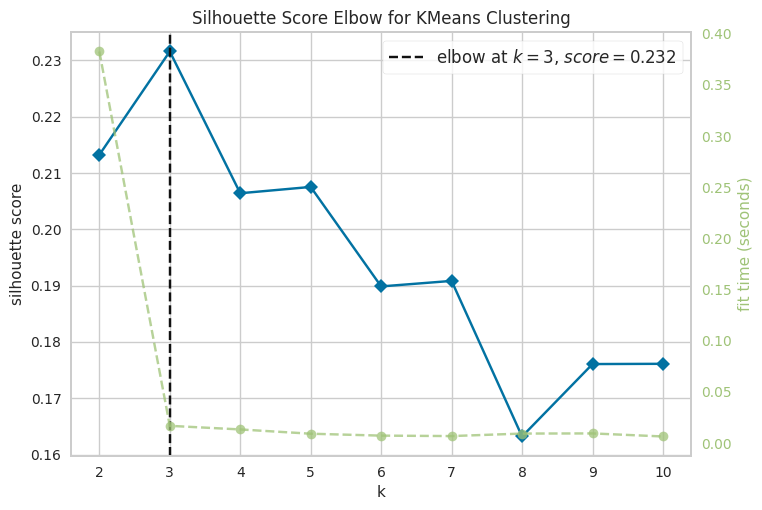

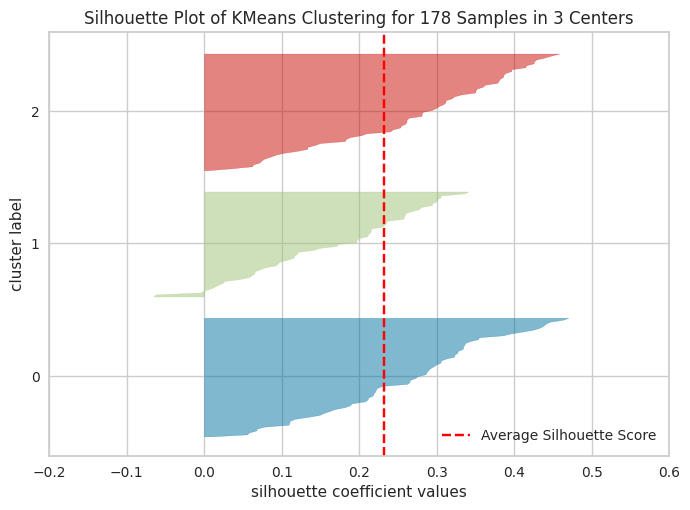

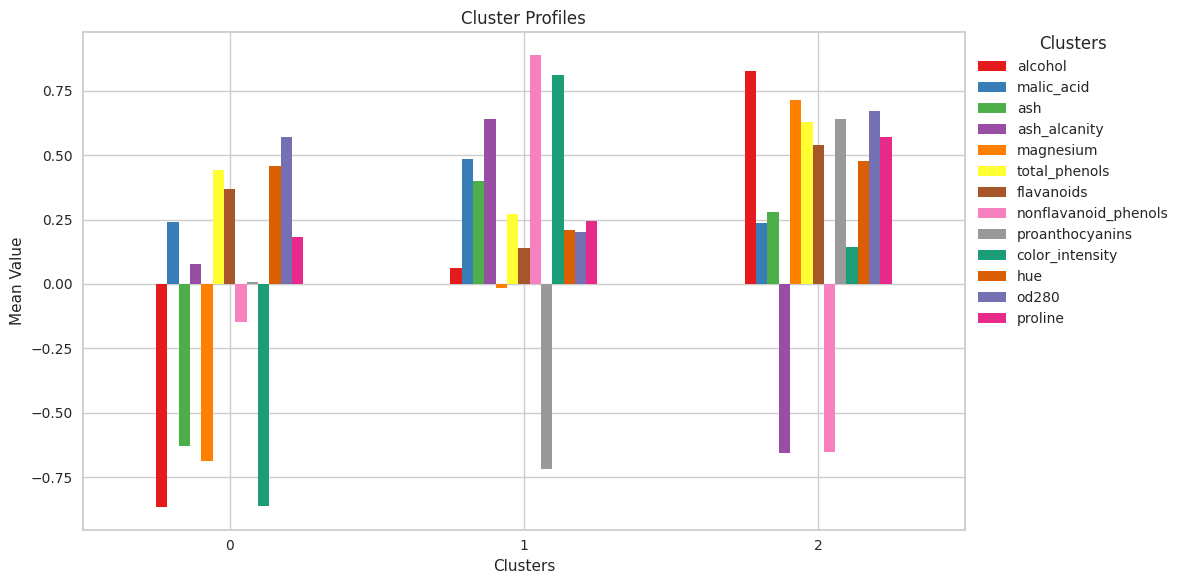

In [6]:
kmeans_best_labels, kmeans_silhouette_score = perform_kmeans_visualization(X_data)
plot_cluster_profiles(X_data, kmeans_best_labels)

# 4 - Perform PCA

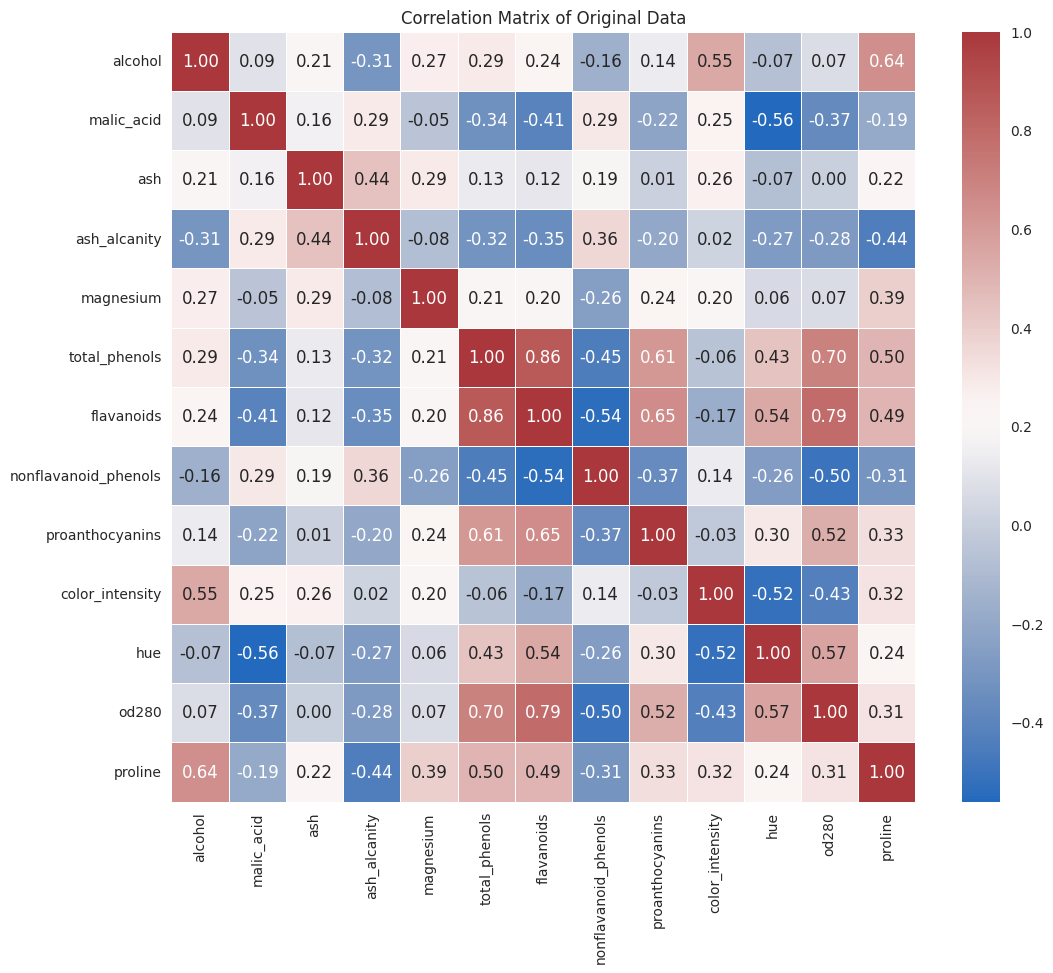


<p>To ensure a robust and reliable Principal Component Analysis (PCA), it's crucial to assess the suitability of our data. Scientific literature<sup id="fnref:1"><a href="#fn:1" class="footnote-ref" role="doc-noteref">1</a></sup> suggests two key criteria:</p> 

* **Kaiser-Meyer-Olkin (KMO) Test:** This test measures the adequacy of our data for factor analysis. A KMO value above 0.6 is generally considered acceptable. 
* **Bartlett's Test of Sphericity:** This test examines whether the correlation matrix of our data is significantly different from an identity matrix. A significant result (p-value < 0.05) indicates that our variables are correlated and suitable for PCA.

**Our Results:**

The KMO test yielded a value of **0.779**, surpassing the recommended threshold. Additionally, Bartlett's test resulted in a p-value of **0.000**, confirming a significant correlation structure within our dataset.

**These results strongly support the application of PCA to our wine data, providing confidence in the robustness and validity of the insights derived from this analysis.** 

<section class="footnotes" role="doc-endnotes">
  <hr>
  <ol>
    <li id="fn:1" role="doc-endnote">
      <p><a href="https://www.sciencedirect.com/book/9780128112168/data-science-for-business-and-decision-making">Data Science for Business and Decision Making</a></p>
    </li>
  </ol>
</section>



PCA Results


Principal Component  Eigenvalue  Variance Percentage  Cumulative Variance
0                     1    2.099593            28.636437            28.636437
1                     2    1.869523            25.498509            54.134946
2                     3    1.192279            16.261548            70.396494
3                     4    0.706149             9.631195            80.027689
4                     5    0.548971             7.487445            87.515134
5                     6    0.497024             6.778927            94.294060
6                     7    0.283946             3.872758            98.166819
7                     8    0.056147             0.765790            98.932609
8                     9    0.031112             0.424340            99.356949
9                    10    0.017748             0.242066            99.599014
10                   11    0.012837             0.175089            99.774103
11                   12    0.011707             0.159673            99.933776
12                   13    0.004855             0.066224           100.000000


Our PCA analysis revealed that the first three principal components each have eigenvalues greater than 1, indicating that they capture at least as much variance as one of the original variables. 
These three components, collectively explaining **70.4%** of the total variance in our dataset, will be used to explore potential clusters within our wine data. 
By focusing on these key components, we aim to uncover hidden groupings based on the most influential characteristics of the wines, allowing for more insightful and actionable interpretations.



1. **Communalities Table**:
   - This table shows how much of each variable's information is captured by the principal components with eigenvalues ≥ 1.
   - Think of it as a measure of how well each variable is represented in the simplified data model.

2. **Bar Chart of Variable Contributions**:
   - The bar chart illustrates the contribution of each variable to the formation of the first three principal components collectively.
   - It highlights which variables play a significant role in shaping the overall data structure.

**How They Relate**:
- Both the table and the chart start from the same point: components with eigenvalues ≥ 1.
- The communalities table tells us how well each variable is captured by these components.
- The bar chart shows us which variables are the main contributors to these components.



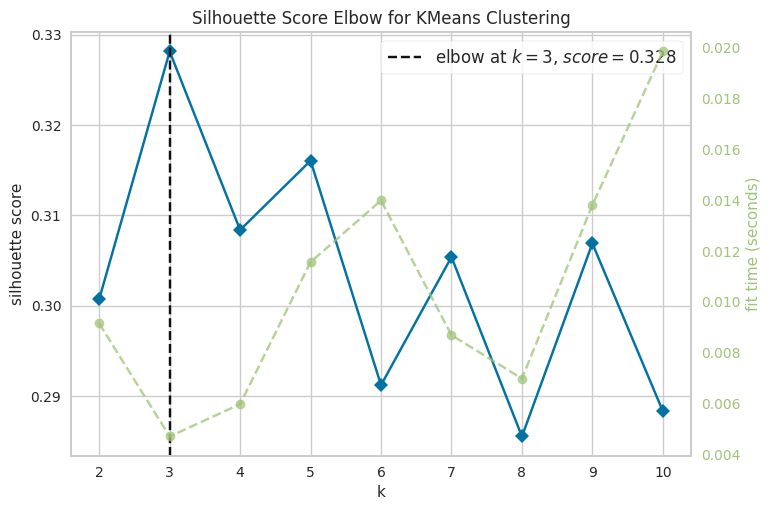

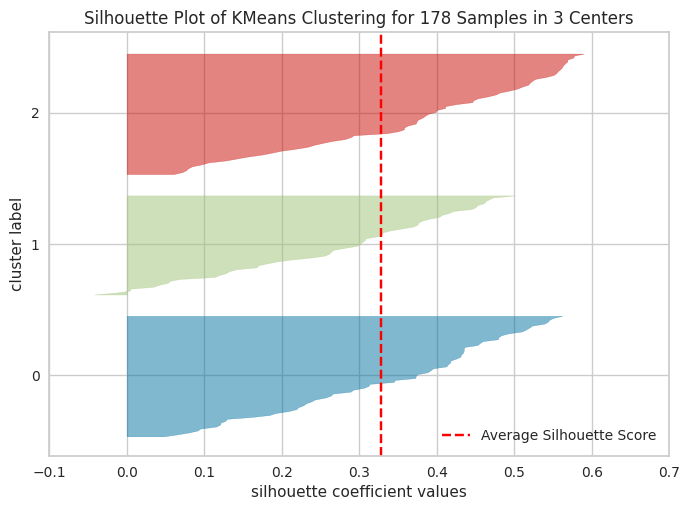

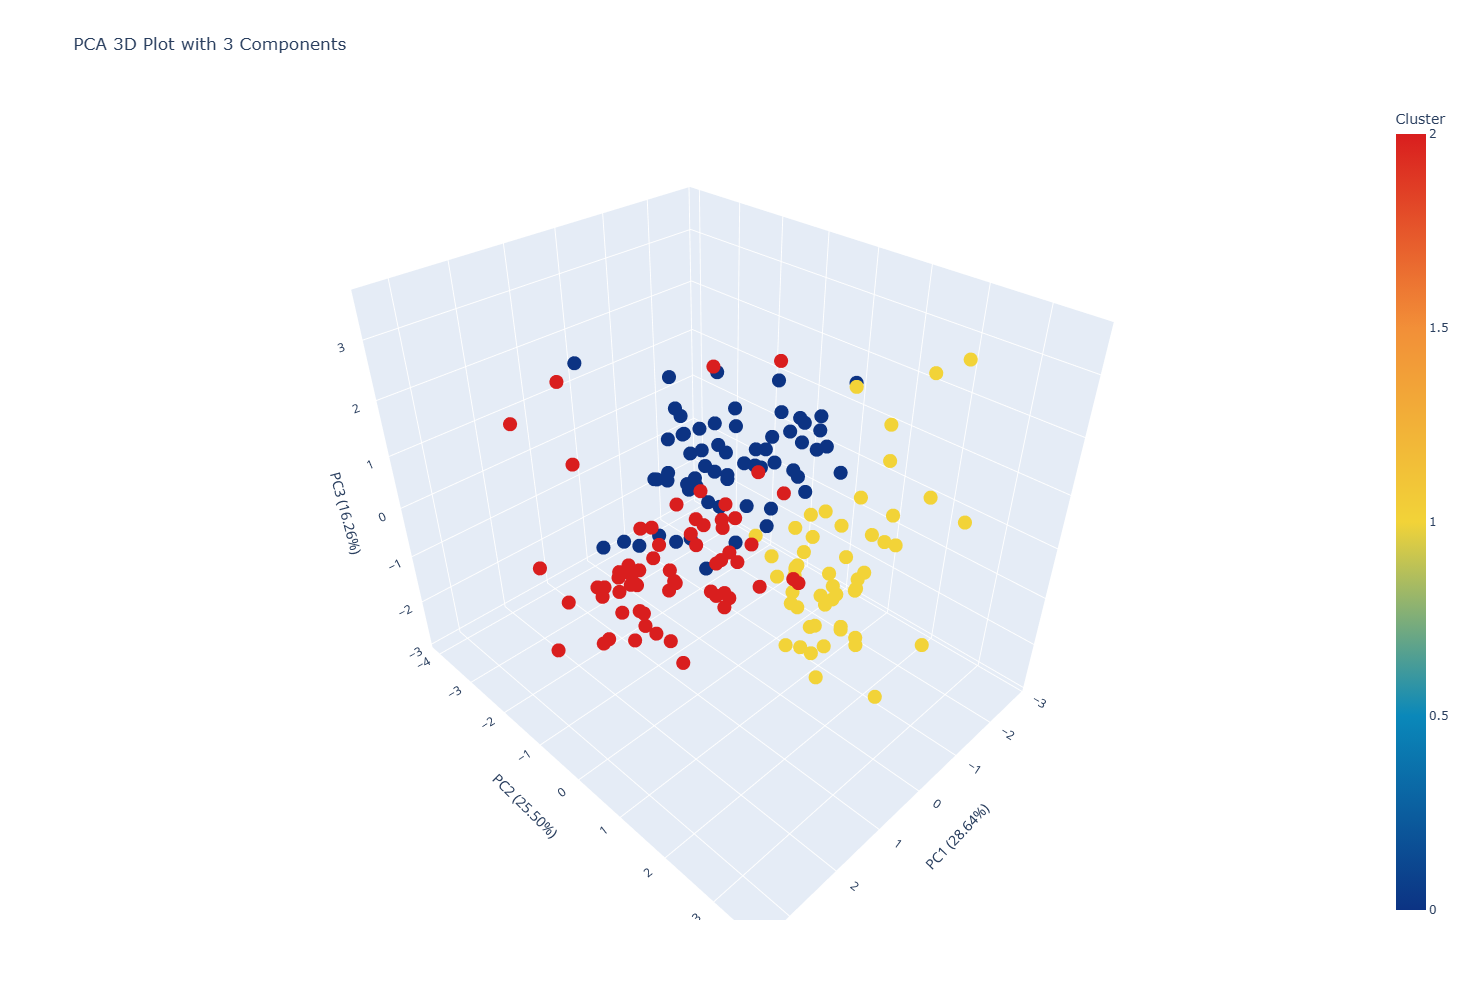

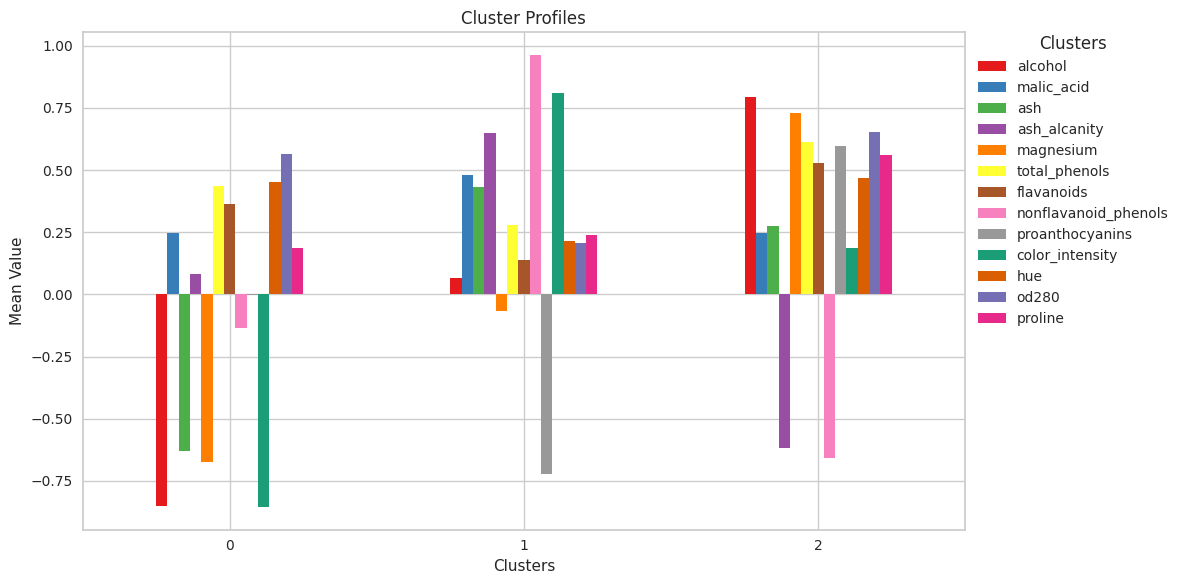

In [8]:
# -------------------------------------------------------------------
# Section 1: Correlation Matrix of Original Data
# -------------------------------------------------------------------
# Calculating the correlation matrix for the original data
correlation_matrix = X_data.corr()
# Plotting the Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', fmt='.2f', 
            linewidths=.5
           )
plt.title('Correlation Matrix of Original Data')
plt.show()

# -------------------------------------------------------------------
# Section 2: KMO and Bartlett's Test
# -------------------------------------------------------------------
kmo_all, kmo_model = calculate_kmo(X_data)
chi_square_value, p_value = calculate_bartlett_sphericity(X_data)

explanation = f"""
<p>To ensure a robust and reliable Principal Component Analysis (PCA), it's crucial to assess the suitability of our data. Scientific literature<sup id="fnref:1"><a href="#fn:1" class="footnote-ref" role="doc-noteref">1</a></sup> suggests two key criteria:</p> 

* **Kaiser-Meyer-Olkin (KMO) Test:** This test measures the adequacy of our data for factor analysis. A KMO value above 0.6 is generally considered acceptable. 
* **Bartlett's Test of Sphericity:** This test examines whether the correlation matrix of our data is significantly different from an identity matrix. A significant result (p-value < 0.05) indicates that our variables are correlated and suitable for PCA.

**Our Results:**

The KMO test yielded a value of **{kmo_model:.3f}**, surpassing the recommended threshold. Additionally, Bartlett's test resulted in a p-value of **{p_value:.3f}**, confirming a significant correlation structure within our dataset.

**These results strongly support the application of PCA to our wine data, providing confidence in the robustness and validity of the insights derived from this analysis.** 

<section class="footnotes" role="doc-endnotes">
  <hr>
  <ol>
    <li id="fn:1" role="doc-endnote">
      <p><a href="https://www.sciencedirect.com/book/9780128112168/data-science-for-business-and-decision-making">Data Science for Business and Decision Making</a></p>
    </li>
  </ol>
</section>
"""

display(Markdown(explanation))

# -------------------------------------------------------------------
# Section 3: Performing PCA
# -------------------------------------------------------------------
pca = PCA()
principal_components = pca.fit_transform(X_data)

# PCA Results
eigenvalues = pca.explained_variance_
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = variance_ratio.cumsum()
pca_table = pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Variance Percentage': variance_ratio * 100,
    'Cumulative Variance': cumulative_variance * 100
})

# Reset the index and create the 'Principal Component' column starting from 1
pca_table = pca_table.reset_index().rename(columns={'index': 'Principal Component'})
pca_table['Principal Component'] = pca_table['Principal Component'] + 1

print('\nPCA Results')
display(pca_table)

explanation = f"""
Our PCA analysis revealed that the first three principal components each have eigenvalues greater than 1, indicating that they capture at least as much variance as one of the original variables. 
These three components, collectively explaining **{pca_table.iloc[2,3]:.1f}%** of the total variance in our dataset, will be used to explore potential clusters within our wine data. 
By focusing on these key components, we aim to uncover hidden groupings based on the most influential characteristics of the wines, allowing for more insightful and actionable interpretations.
"""

display(Markdown(explanation))
# -------------------------------------------------------------------
# Section 4: Loadings and Communalities (Eigenvalues >= 1)
# -------------------------------------------------------------------
# Get loadings (principal component loadings)
loadings = pca.components_

# Select components with eigenvalues >= 1
n_components = sum(pca_table['Eigenvalue'] >= 1)
loadings_selected = loadings[:, :n_components]

# Calculate communalities considering only the selected components
communalities = np.sum(loadings_selected**2, axis=1)

# Communalities Table (rounded to 3 decimal places)
communalities_table = pd.DataFrame({
    'Variable': X_data.columns,
    'Communality': communalities.round(3)  # Rounded to 3 decimal places
}).sort_values(by='Communality', ascending=False)
# display(communalities_table)

# -------------------------------------------------------------------
# Section 5: Contributions of Variables (Eigenvalues >= 1)
# -------------------------------------------------------------------
# Filter components with eigenvalues >= 1
components_to_keep = eigenvalues >= 1
filtered_components = pca.components_[components_to_keep]

# Get the contributions of the variables
contrib = pd.DataFrame(filtered_components, columns=X_data.columns).abs().sum().sort_values(ascending=True)

# Create the interactive contributions chart using Plotly
fig = go.Figure(data=go.Bar(x=contrib.values, y=contrib.index, orientation='h', marker=dict(color=contrib.values, colorscale='Viridis_r')))
fig.update_layout(
    title='Original Variable Contributions to Top Principal Components (Eigenvalues ≥ 1)',
    xaxis_title='Contribution',
    yaxis_title='Variables',
    height=600,
    width=1000
)

# Display Communalities DataFrame and chart side by side
display(HTML("""
<div style="display: flex;">
    <div style="flex: 50%; padding: 10px;">
        <h3>Communalities Table</h3>
        {0}
    </div>
    <div style="flex: 50%; padding: 10px;">
        {1}
    </div>
</div>
""".format(communalities_table.to_html(), fig.to_html())))

explanation = f"""
1. **Communalities Table**:
   - This table shows how much of each variable's information is captured by the principal components with eigenvalues ≥ 1.
   - Think of it as a measure of how well each variable is represented in the simplified data model.

2. **Bar Chart of Variable Contributions**:
   - The bar chart illustrates the contribution of each variable to the formation of the first three principal components collectively.
   - It highlights which variables play a significant role in shaping the overall data structure.

**How They Relate**:
- Both the table and the chart start from the same point: components with eigenvalues ≥ 1.
- The communalities table tells us how well each variable is captured by these components.
- The bar chart shows us which variables are the main contributors to these components.

"""

display(Markdown(explanation))
# -------------------------------------------------------------------
# Section 6: PCA and KMeans 
# -------------------------------------------------------------------
pca_best_labels, pca_silhouette_score = perform_pca_kmeans(X_data, n_components)
plot_cluster_profiles(X_data, pca_best_labels)


# 5 - Affinity Propagation


Best Preference: -210
Best Silhouette Score: 0.2238
N Clusters: 3


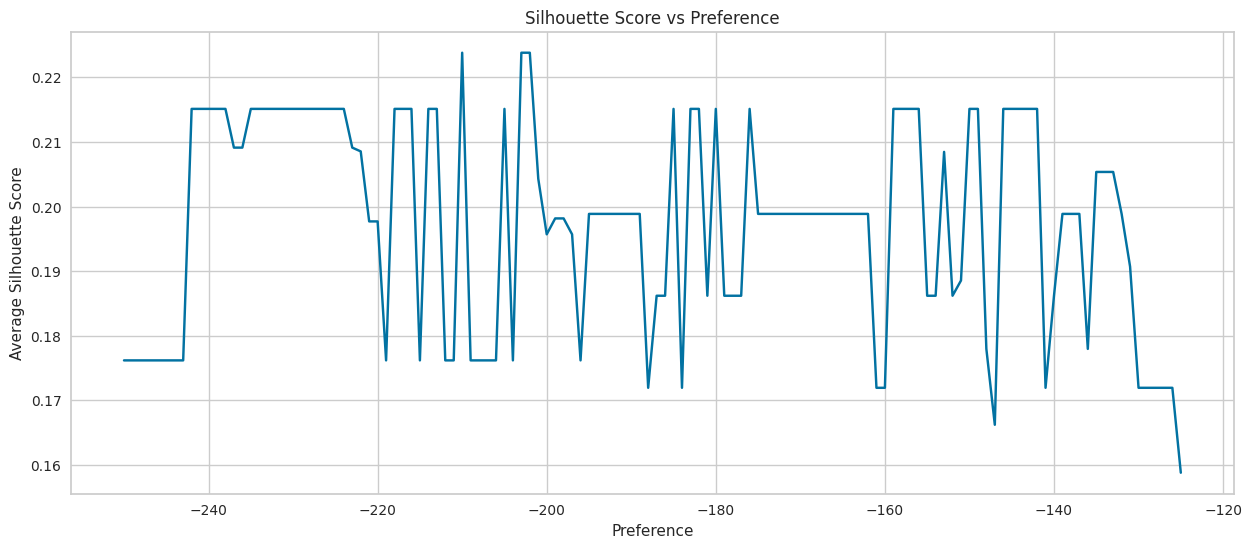

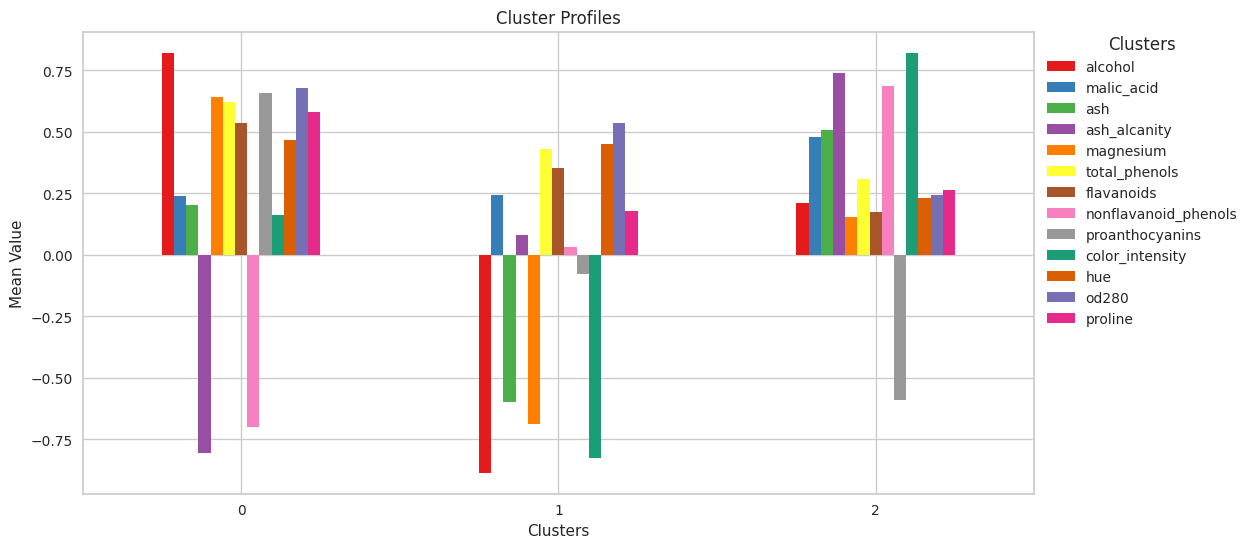

In [9]:
# Define the preferences to be tested
preferences = range(-250,-124)

# Perform grid search
affinity_propagation_best_preference, affinity_propagation_best_ss, affinity_propagation_best_labels = perform_affinity_propagation_grid_search(X_data, preferences)

df_affinity_propagation = X_data.copy()
df_affinity_propagation['cluster'] = affinity_propagation_best_labels

affinity_propagation_cluster_profiles = df_affinity_propagation.groupby('cluster').mean()

# Create a color palette
palette_set1 = sns.color_palette("Set1", 9) 
palette_dark2 = sns.color_palette("Dark2", 4)  
palette_custom = palette_set1 + palette_dark2 

# Bar Plot
fig, ax = plt.subplots(figsize=(12.28, 6))
affinity_propagation_cluster_profiles.plot(kind='bar', ax=ax, color=palette_custom)
# cluster_profiles.plot(kind='bar')
plt.xlabel('Clusters')
plt.ylabel('Mean Value')
plt.title('Cluster Profiles')
plt.legend(title='Clusters', bbox_to_anchor=(1, 1.02))
plt.xticks(rotation=0)
plt.show()

## Wine Cluster Analysis 🍷🥂

### To make it easier to understand, ChatGPT/Copilot were used to get a practical interpretation of the result achieved.

### Cluster 0
- **Characteristics**:
  - **Low Alcohol Content**: These wines have less alcohol, resulting in a lighter taste.
  - **Rich in Antioxidants**: High levels of total phenols and flavonoids, which are good for health.
  - **Less Colorful**: These wines are visually lighter.

- **Suitable Occasions**:
  - **Outdoor Lunches**: Perfect for picnics or barbecues where light and refreshing wines are ideal.
  - **Casual Gatherings**: Great for relaxed get-togethers with friends and family.
  - **Pairing with Light Dishes**: Complements salads and light meals well.
  - **Everyday Drinking**: Suitable for casual, everyday drinking. Think of a relaxed evening with friends or a light lunch where you don’t want the wine to overpower the meal.

### Cluster 1
- **Characteristics**:
  - **High Acidity**: These wines have more malic acid, giving them a fresher and more acidic taste.
  - **More Colorful**: Visually vibrant wines.
  - **Distinct Chemical Composition**: High levels of non-flavonoid phenols and low levels of proanthocyanins.

- **Suitable Occasions**:
  - **Formal Dinners**: Ideal for pairing with sophisticated dishes like seafood or gourmet meals.
  - **Wine Tastings**: Great for events where a variety of flavors and colors are appreciated.
  - **Pairing with Acidic Dishes**: Complements dishes with a touch of acidity, like ceviche or salads with vinaigrette.
  - **Dinners with Strong Flavors**: These wines might pair well with dishes that have rich, creamy sauces or strong spices.

### Cluster 2
- **Characteristics**:
  - **High Alcohol Content**: These wines have more alcohol, resulting in a stronger taste.
  - **Rich in Minerals**: High levels of magnesium.
  - **Rich in Antioxidants**: High levels of total phenols and flavonoids.

- **Suitable Occasions**:
  - **Special Celebrations**: Perfect for toasting on special occasions like birthdays or holiday parties.
  - **Hearty Dinners**: Ideal for pairing with heavier dishes like red meats or rich sauces.
  - **Winter Nights**: Great for warming up on cold nights, providing a more intense and comforting flavor.
  - **Special Occasions**: These wines might be richer, with more body and a complex flavor profile, making them ideal for special occasions.

### Summary
- **Cluster 0**: Light and refreshing wines, ideal for casual occasions and light meals.
- **Cluster 1**: Acidic and vibrant wines, perfect for formal dinners and tastings.
- **Cluster 2**: Strong and intense wines, ideal for special celebrations and hearty dinners.


# 5 - Comparison between the results from the two methods 📊📈

Adjusted Rand Index (ARI): 0.7691838802303653



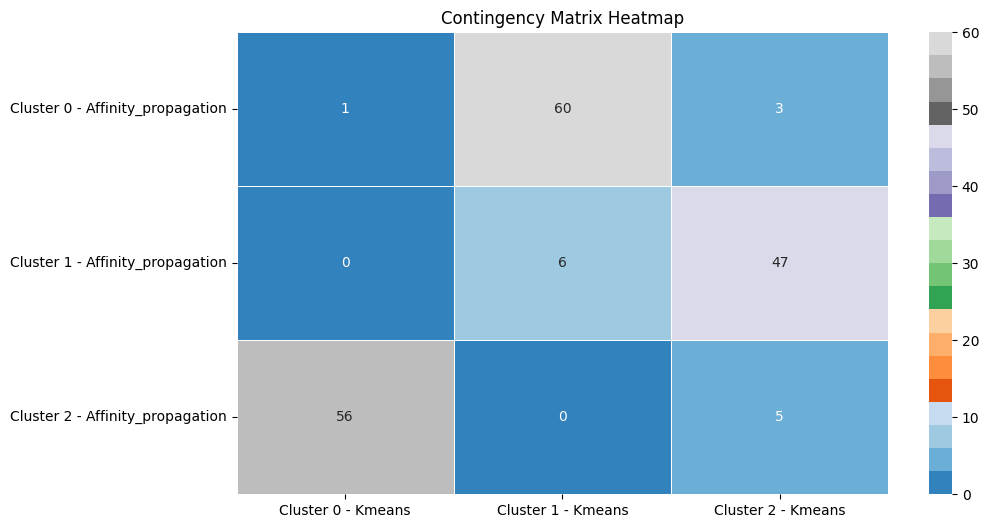

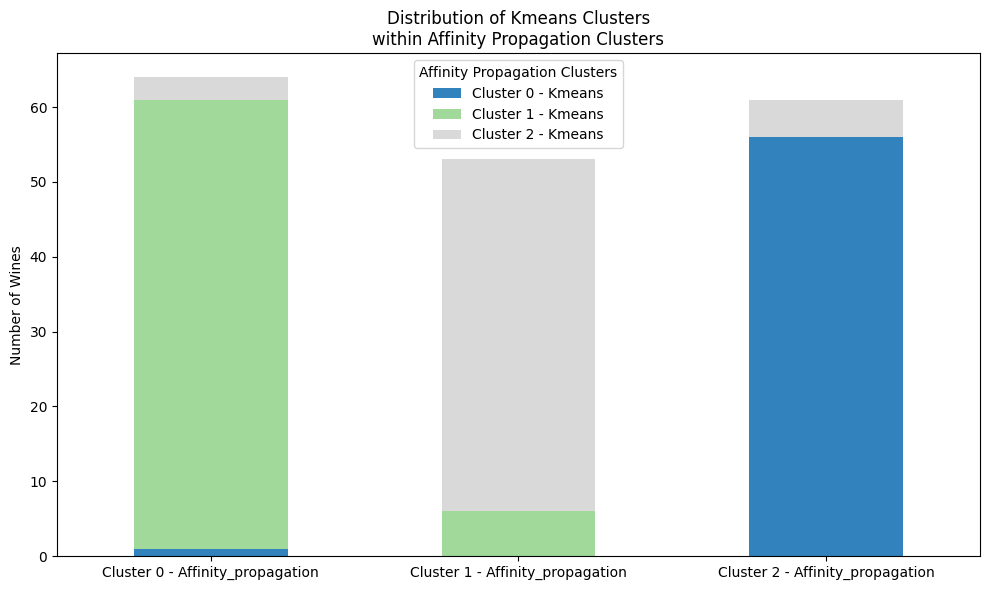

In [8]:
# Calculate the contingency matrix
contingency = contingency_matrix(kmeans_best_labels, affinity_propagation_best_labels)

# Calculate the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(kmeans_best_labels, affinity_propagation_best_labels)

print(f'Adjusted Rand Index (ARI): {ari}\n')

# Create a DataFrame from the contingency matrix
df_contingency = pd.DataFrame(contingency, columns=['Cluster 0 - Kmeans', 'Cluster 1 - Kmeans', 'Cluster 2 - Kmeans'],
                              index=['Cluster 0 - Affinity_propagation', 'Cluster 1 - Affinity_propagation', 'Cluster 2 - Affinity_propagation'])

# Create a heatmap from the contingency matrix
plt.figure(figsize=(10.51, 6))
sns.heatmap(df_contingency, 
            annot=True, 
            # cmap=sns.color_palette(custom_palette, as_cmap=True), 
            cmap='tab20c', 
            fmt='d', linewidths=0.5
           )
plt.title('Contingency Matrix Heatmap')
# plt.xlabel('Kmeans Clusters')
# plt.ylabel('Affinity Propagation Clusters')
plt.show()


# Configure the stacked bar chart
df_contingency.plot(kind='bar', 
                    stacked=True, 
                    figsize=(10, 6), 
                    colormap='tab20c')
plt.title('Distribution of Kmeans Clusters\nwithin Affinity Propagation Clusters')
# plt.xlabel('Kmeans Clusters')
plt.ylabel('Number of Wines')
plt.legend(title='Affinity Propagation Clusters')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Results from the Contingency Matrix and ARI Index

**Contingency Matrix Heatmap:**
The heatmap gives us a visual representation of how the two clustering methods — **_K-means_** and **_Affinity Propagation_** — overlap in grouping the data. Darker shades in the heatmap show where there's a higher number of data points grouped together by both methods.

- **Key Takeaways:**
  - **Overlap Between Groups:** We see a strong overlap between Cluster 0 (K-means) and Cluster 2 (Affinity Propagation), as well as between Cluster 1 (K-means) and Cluster 0 (Affinity Propagation). This suggests that both methods agree quite well in grouping these data points.
  - **Moderate Agreement:** There's a moderate overlap between Cluster 2 (K-means) and Cluster 1 (Affinity Propagation), indicating some alignment between the methods, though not as strong as in the other clusters.

**Adjusted Rand Index (ARI):**
The ARI score of 0.769 suggests a high level of agreement between the two clustering methods. This is a good sign, indicating that both methods are identifying similar patterns in the data, making our clustering results more reliable.

**Distribution of K-means Clusters within Affinity Propagation Clusters:**
This bar chart breaks down how data points assigned to clusters by K-means are distributed within the clusters identified by Affinity Propagation.

- **Key Takeaways:**
  - **Strong Consistency:** Most of the data points in Cluster 0 (Affinity Propagation) are also classified into the same group by K-means, showing strong consistency between the methods.
  - **Diverse Grouping:** Cluster 1 (Affinity Propagation) has a mix of data points from different K-means clusters, suggesting that the two methods have some differences in how they group these points.
  - **Agreement:** Similar to Cluster 0, Cluster 2 (Affinity Propagation) shows a strong agreement with the K-means classification.

### Summary and Business Implications

These findings show that the two clustering methods we used are largely in agreement, which is a strong indicator that our data segmentation is reliable.

- **Consistency in Clustering:** The alignment between the two methods means that the identified groups are dependable and can be used for making strategic business decisions.
- **Actionable Insights:** With consistent clusters, we can confidently move forward with tailored strategies, whether it’s personalized marketing, enhancing customer experiences, or optimizing resources.
- **Understanding Your Customers:** As discussed earlier, understanding the characteristics of each cluster (e.g., rich and complex wines for special occasions, light and casual wines for everyday enjoyment) can guide product recommendations and improve customer satisfaction. 

This approach helps bridge the gap between data analysis and actionable business insights, making the results accessible and useful for decision-making.

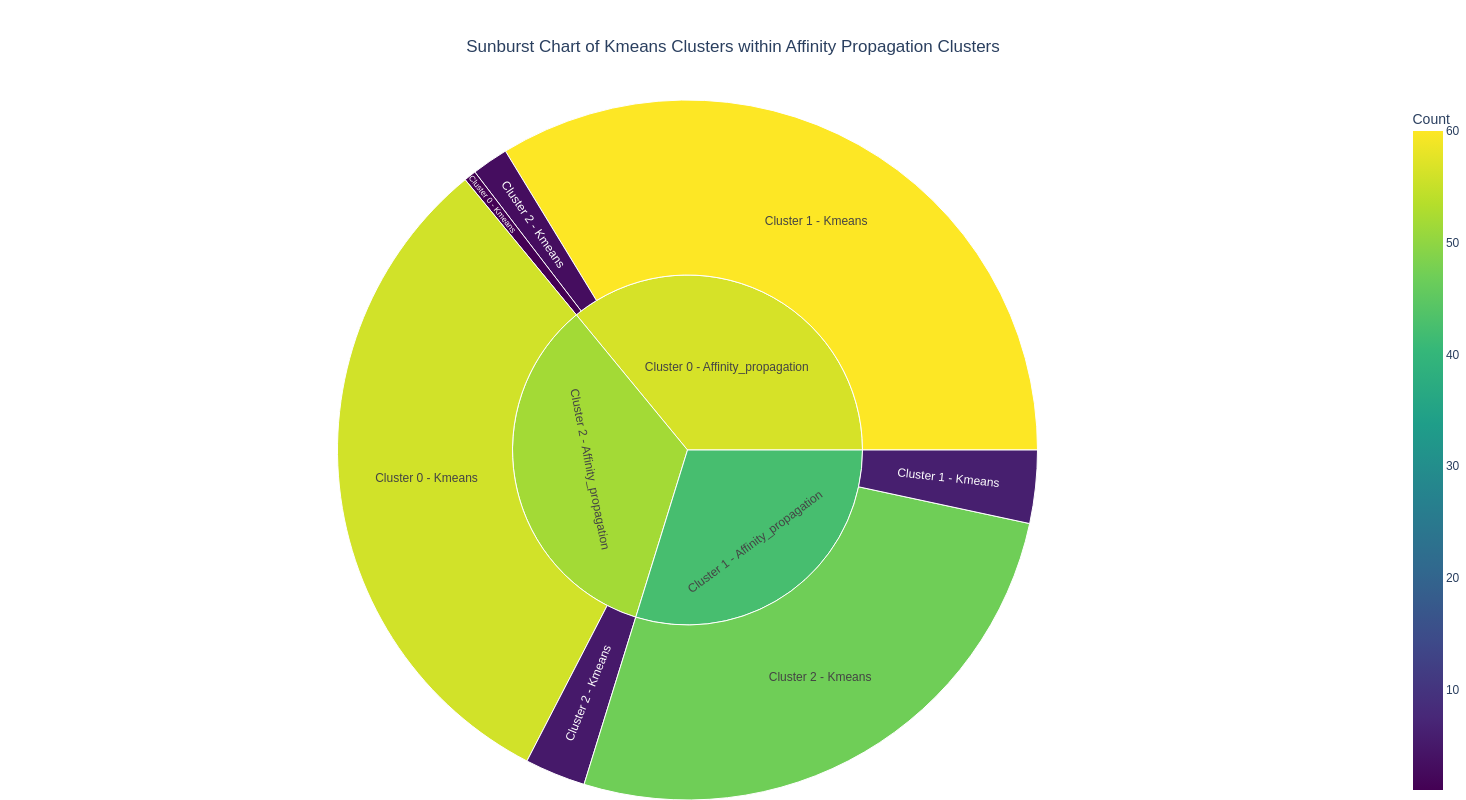

In [9]:
import plotly.express as px
import pandas as pd

# Ensure the DataFrame is correctly structured
sunburst_df = df_contingency.reset_index().melt(id_vars='index', var_name='Kmeans Cluster', value_name='Count')
sunburst_df = sunburst_df[sunburst_df['Count'] > 0]

sunburst_df.columns = ['Affinity Propagation Cluster', 'Kmeans Cluster', 'Count']

# Create a sunburst chart
fig = px.sunburst(sunburst_df, path=['Affinity Propagation Cluster', 'Kmeans Cluster'], values='Count', 
                  color='Count', color_continuous_scale='viridis')

# Update layout with specific height and title
fig.update_layout(
    title_text='Sunburst Chart of Kmeans Clusters within Affinity Propagation Clusters',  # Set the title text
    title_x=0.5,  # Center the title horizontally
    title_y=0.95,  # Adjust the vertical position of the title
    margin=dict(t=100, l=0, r=0, b=0),  # Add more margin on top to make room for the title
    height=800  # Adjust height as needed
)

fig.show()